In [20]:
import os
from reportparse.reader.base import BaseReader
from reportparse.annotator.base import BaseAnnotator

reader = BaseReader.by_name('pymupdf')()
document = reader.read(input_path='./reportparse/asset/example.pdf')

document = BaseAnnotator.by_name("climate")().annotate(document=document)
document = BaseAnnotator.by_name("climate_commitment")().annotate(document=document)
document = BaseAnnotator.by_name("climate_sentiment")().annotate(document=document)
document = BaseAnnotator.by_name("climate_specificity")().annotate(document=document)
document = BaseAnnotator.by_name("llm_agg")().annotate(document=document)

[0310 22:02.25 @pymupdf_reader.py:205]  WRN  The "read" method received the "args" argument, which means any other optional arguments will be ignored.
[0310 22:02.25 @pymupdf_reader.py:163]  INF  Read page 0
[0310 22:02.25 @pymupdf_reader.py:37]  INF  	Load images from the page 0
[0310 22:02.25 @pymupdf_reader.py:186]  INF  	Read blocks
[0310 22:02.26 @pymupdf_reader.py:109]  INF  	Apply the sentence tokenization by SpaCy
[0310 22:02.26 @pymupdf_reader.py:163]  INF  Read page 1
[0310 22:02.26 @pymupdf_reader.py:37]  INF  	Load images from the page 1
[0310 22:02.26 @pymupdf_reader.py:186]  INF  	Read blocks
[0310 22:02.26 @pymupdf_reader.py:109]  INF  	Apply the sentence tokenization by SpaCy
[0310 22:02.26 @pymupdf_reader.py:163]  INF  Read page 2
[0310 22:02.26 @pymupdf_reader.py:37]  INF  	Load images from the page 2
[0310 22:02.26 @pymupdf_reader.py:186]  INF  	Read blocks
[0310 22:02.26 @pymupdf_reader.py:109]  INF  	Apply the sentence tokenization by SpaCy
[0310 22:02.26 @pymupdf_

Starting storing in Chroma
Stored page 0


[0310 22:02.28 @local_persistent_hnsw.py:339]  WRN  Add of existing embedding ID: example.pdf_page_1_chunk_0
[0310 22:02.28 @local_persistent_hnsw.py:339]  WRN  Add of existing embedding ID: example.pdf_page_1_chunk_1
[0310 22:02.28 @local_persistent_hnsw.py:339]  WRN  Add of existing embedding ID: example.pdf_page_1_chunk_2
[0310 22:02.28 @local_persistent_hnsw.py:339]  WRN  Add of existing embedding ID: example.pdf_page_2
[0310 22:02.28 @local_persistent_hnsw.py:339]  WRN  Add of existing embedding ID: example.pdf_page_2_chunk_0
[0310 22:02.28 @local_persistent_hnsw.py:339]  WRN  Add of existing embedding ID: example.pdf_page_2_chunk_1
[0310 22:02.28 @local_persistent_hnsw.py:339]  WRN  Add of existing embedding ID: example.pdf_page_2_chunk_2
[0310 22:02.28 @local_persistent_hnsw.py:339]  WRN  Add of existing embedding ID: example.pdf_page_2_chunk_3
[0310 22:02.28 @local_persistent_hnsw.py:339]  WRN  Add of existing embedding ID: example.pdf_page_3


Stored page 1
Stored page 2


[0310 22:02.28 @local_persistent_hnsw.py:339]  WRN  Add of existing embedding ID: example.pdf_page_3_chunk_0
[0310 22:02.28 @local_persistent_hnsw.py:339]  WRN  Add of existing embedding ID: example.pdf_page_3_chunk_1
[0310 22:02.28 @local_persistent_hnsw.py:339]  WRN  Add of existing embedding ID: example.pdf_page_3_chunk_2
[0310 22:02.28 @local_persistent_hnsw.py:339]  WRN  Add of existing embedding ID: example.pdf_page_3_chunk_3


Stored page 3
Stored page 4
Stored page 5
Successfully stored all pages in chroma
Checking the first 1 pages for greenwashing


[0310 22:02.34 @_client.py:1025]  INF  HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
[0310 22:03.11 @chroma_annotator.py:179]  INF  Retrieving context from ChromaDB
[0310 22:03.11 @chroma_annotator.py:251]  INF  Calling LLM to verify claim with context


AI message 1:  Potential greenwashing claim: "Achieving a Decarbonized Society"
Justification: The report claims to achieve a decarbonized society, but it does not provide specific details on how this goal is being met or what concrete actions are being taken to reduce greenhouse gas emissions.

Potential greenwashing claim: "Contributing to a Decarbonized Society Through the Decarbonization Business"
Justification: This claim is vague and does not provide clear information on the scope, impact, or effectiveness of Hitachi's decarbonization efforts.
distance:  0.7569488286972046
Retrieved pages:  []


[0310 22:03.11 @_client.py:1025]  INF  HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


AI message:  Statement: "Achieving a Decarbonized Society"

Result of the statement: PARTIALLY TRUE

Justification:

The statement is partially true because Hitachi Ltd. has set long-term environmental targets, including achieving a decarbonized society by 2050, as outlined in their "Hitachi Environmental Innovation 2050" initiative. Additionally, they have established metrics and targets to measure progress towards this goal, such as reducing CO2 emissions per unit and utilizing the Hitachi Internal Carbon Pricing (HICP) system.

However, the statement is not entirely accurate because it implies that Hitachi has already achieved a decarbonized society, which is not the case. The report states that while they have made progress in reducing CO2 emissions, there are still challenges to be addressed, such as fluctuating total CO2 emissions from Scope 3 activities due to changes in sales volumes and business portfolio.

Furthermore, the statement does not mention the importance of contribu

[0310 22:03.14 @lib.rs:450]  INF  response: https://duckduckgo.com/?q=%22Achieving+a+Decarbonized+Society%22 200


html
pdf
html
Harvesting url: https://www.hitachi.com/sustainability/report/environmental/decarbonization.html


Batches: 100%|██████████| 5/5 [00:00<00:00, 17.62it/s]


Invoking with the first llm...


[0310 22:03.36 @llm_aggregator.py:89]  INF  Calling LLM to verify claim with context
[0310 22:03.36 @_client.py:1025]  INF  HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
[0310 22:03.38 @chroma_annotator.py:179]  INF  Retrieving context from ChromaDB
[0310 22:03.38 @chroma_annotator.py:251]  INF  Calling LLM to verify claim with context


AI message:  Statement: "Achieving a Decarbonized Society"

Result of the statement: PARTIALLY TRUE

Justification:

The Database Verdict provides a more nuanced assessment, highlighting that while Hitachi has set ambitious targets and established metrics to measure progress, they have not yet achieved a decarbonized society. The report acknowledges ongoing challenges and the need for continued efforts to address these issues.

In contrast, the Web Verdict is overly simplistic, as it does not consider the complexities and nuances of Hitachi's current status. While the title "Achieving a Decarbonized Society" may be accurate in terms of the company's goals, it does not accurately reflect their current level of achievement.

Therefore, considering both verdicts, I conclude that the statement is partially true, as Hitachi has made progress towards achieving a decarbonized society, but there is still work to be done. The Web Verdict's assertion that the statement is true oversimplifies the

[0310 22:03.39 @_client.py:1025]  INF  HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


AI message:  Statement: "Contributing to a Decarbonized Society Through the Decarbonization Business"

Result of the statement: PARTIALLY TRUE

Justification:

The statement is partially true because Hitachi does indeed aim to contribute to a decarbonized society through its decarbonization business. The company has set long-term environmental targets, including achieving a decarbonized society, and has established metrics and targets to measure progress.

However, the statement is not entirely accurate because it implies that Hitachi's decarbonization efforts are solely focused on reducing CO2 emissions at its own business sites (factories and offices). While the company does reduce CO2 emissions from these sources using the Hitachi Internal Carbon Pricing (HICP) system, the statement overlooks the fact that Hitachi also aims to calculate GHG emissions throughout its entire value chain.

Furthermore, the statement does not mention the importance of environmental governance in achievin

[0310 22:03.42 @lib.rs:450]  INF  response: https://duckduckgo.com/?q=%22Contributing+to+a+Decarbonized+Society+Through+the+Decarbonization+Business%22 200
[0310 22:03.43 @llm_aggregator.py:89]  INF  Calling LLM to verify claim with context


pdf
pdf
pdf
Could not find relevant sources.
Result is None


[0310 22:03.44 @_client.py:1025]  INF  HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


AI message:  Statement: "Contributing to a Decarbonized Society Through the Decarbonization Business"

Result of the statement: PARTIALLY TRUE

Justification:

The Database Verdict provides strong confirmation that Hitachi aims to contribute to a decarbonized society through its decarbonization business, as evidenced by the company's long-term environmental targets and metrics for measuring progress. However, the Web Verdict's lack of information from the web means that we cannot verify or contradict this claim directly.

Given the Database Verdict's confirmation and the absence of contradictory evidence from the Web Verdict, I rely on the structured database to inform my conclusion. The justification provided by the Database Verdict highlights Hitachi's efforts to reduce CO2 emissions throughout its entire value chain, not just at its own business sites.

While the statement is partially true, it lacks context regarding environmental governance, which is crucial for achieving a decarb

In [21]:
if not os.path.exists('./results'):
    os.makedirs('./results')

# Save the full data as a JSON file
document.save('./results/example.pdf.json')
# Save the easy-to-use dataset as a CSV file
df = document.to_dataframe(level='block')
df_2 = document.to_dataframe(level='page')

In [22]:
print(df)

        page_id              block_id block_layout_type  \
0    page_idx_0   -338662669616057431              text   
1    page_idx_0  -6141761642586137555              text   
2    page_idx_0  -2727539719969651667              text   
3    page_idx_0   1319615417483931358              text   
4    page_idx_0    504742589709628036              text   
..          ...                   ...               ...   
112  page_idx_5   3456605633321372939              text   
113  page_idx_5   3038824898059928662              text   
114  page_idx_5  -7266134418938778719              text   
115  page_idx_5   -256627500594058200              text   
116  page_idx_5  -4237186339689253465              text   

                                            block_bbox  \
0    (141.7324981689453, 68.15635681152344, 4192.91...   
1    (141.7324981689453, 299.5753173828125, 2012.86...   
2    (1110.2362060546875, 574.18701171875, 2062.130...   
3    (2173.228271484375, 299.5753173828125, 3104.15...   
4

In [23]:
# eda
print(df.describe())
print(df.info())
print(df.head())
print(df.tail())
print(df.columns)
print(df.index)

       climate-score  climate_commitment-score  climate_sentiment-score  \
count     117.000000                 96.000000                96.000000   
mean        0.960199                  0.937798                 0.798049   
std         0.093943                  0.109675                 0.134172   
min         0.527090                  0.553820                 0.484509   
25%         0.983218                  0.938639                 0.698665   
50%         0.994967                  0.991210                 0.831792   
75%         0.997377                  0.996822                 0.921322   
max         0.998404                  0.999325                 0.983409   

       climate_specificity-score  
count                  96.000000  
mean                    0.754204  
std                     0.123487  
min                     0.501759  
25%                     0.663482  
50%                     0.783210  
75%                     0.848002  
max                     0.968171  
<class 'p

In [24]:
# eda for df_2
print(df_2.describe())
print(df_2.info())
print(df_2.head())
print(df_2.tail())
print(df_2.columns)
print(df_2.index)

       page_num    page_width   page_height
count  6.000000  6.000000e+00  6.000000e+00
mean   2.500000  4.405500e+03  4.405500e+03
std    1.870829  9.963015e-13  9.963015e-13
min    0.000000  4.405500e+03  4.405500e+03
25%    1.250000  4.405500e+03  4.405500e+03
50%    2.500000  4.405500e+03  4.405500e+03
75%    3.750000  4.405500e+03  4.405500e+03
max    5.000000  4.405500e+03  4.405500e+03
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   page_id            6 non-null      object 
 1   page_num           6 non-null      int64  
 2   page_width         6 non-null      float64
 3   page_height        6 non-null      float64
 4   page_text          6 non-null      object 
 5   First pass         1 non-null      object 
 6   chroma_result      1 non-null      object 
 7   web_rag_result     1 non-null      object 
 8   aggregator_result  

In [12]:
from pymongo import MongoClient
import json

# Load the JSON file
with open("./results/example.pdf.json", "r", encoding="utf-8") as file:
    data = json.load(file)  # Parses JSON into a Python dictionary or list

# Connect to MongoDB (default localhost:27017)
client = MongoClient("mongodb://localhost:27017/")
db = client["pdf_annotations"]  # Database name
collection = db["annotations"]  # Collection name

collection.insert_one(data) 

InsertOneResult(ObjectId('67cf44db3d1cb875574caeba'), acknowledged=True)

In [14]:
print(type(data))  # Should print <class 'list'> or <class 'dict'>


<class 'dict'>


In [15]:
import pprint

if isinstance(data, dict):  # If it's a dictionary
    pprint.pprint(list(data.items())[:2])  # Show first 2 key-value pairs
else:  # If it's a list, use slicing
    pprint.pprint(data[:2])


[('name', 'example.pdf'),
 ('pages',
  [{'annotations': [{'annotator': 'First pass',
                     'meta': {'info': 'Simple greenwashing detection'},
                     'value': 'Potential greenwashing claim: "Achieving a '
                              'Decarbonized Society"\n'
                              'Justification: The report claims to achieve a '
                              'decarbonized society, but it does not provide '
                              'specific details on how this goal is being met '
                              'or what concrete actions are being taken to '
                              'reduce greenhouse gas emissions.\n'
                              '\n'
                              'Potential greenwashing claim: "Contributing to '
                              'a Decarbonized Society Through the '
                              'Decarbonization Business"\n'
                              'Justification: This claim is vague and does not '
     

In [11]:
import json
from pymongo import MongoClient

with open("results/example.pdf.json", "r", encoding="utf-8") as file:
    data = json.load(file)

client = MongoClient("mongodb://localhost:27017/")
db = client["greenwashing_db"]
collection = db["reports"]

pdf_id = data["name"]
new_pages = data["pages"]

existing_doc = collection.find_one({"name": pdf_id})

if existing_doc:
    existing_pages = {page["num"] for page in existing_doc["pages"]}
    new_pages_to_insert = [page for page in new_pages if page["num"] not in existing_pages]

    if new_pages_to_insert:
        collection.update_one(
            {"name": pdf_id},
            {"$push": {"pages": {"$each": new_pages_to_insert}}}
        )
        print(f"Inserted {len(new_pages_to_insert)} new pages into {pdf_id}.")
    else:
        print(f"No new pages to insert for {pdf_id}.")
else:
    collection.insert_one(data)
    print(f"Inserted full document with {len(new_pages)} pages from {pdf_id}.")

result = collection.find_one({"name": pdf_id})
print(f"Final document contains {len(result['pages'])} pages.")


No new pages to insert for example.pdf.
Final document contains 6 pages.


In [14]:
from logging import getLogger
import traceback
import argparse
import os
import pandas as pd
import ollama
import chromadb
import requests
from reportparse.structure.document import Document
import re
from reportparse.db_rag.db import ChromaDBHandler
from langchain_groq import ChatGroq

logger = getLogger(__name__)


document = Document.from_json_file('results/example.pdf.json')
df = document.to_dataframe(level='page')
print(df)
print()
print(df.columns)

print()
# print first pass chroma result and web rag result for page 1
page_1 = document.pages[0]
# print(page_1.get_annotation("chroma"))
# print(page_1.get_annotation("web_rag"))

# print the same from df
# print(df.loc[0, "chroma_result"])

      page_id  page_num   page_width  page_height  \
0  page_idx_0         0  4405.499776  4405.499776   
1  page_idx_1         1  4405.499776  4405.499776   
2  page_idx_2         2  4405.499776  4405.499776   
3  page_idx_3         3  4405.499776  4405.499776   
4  page_idx_4         4  4405.499776  4405.499776   
5  page_idx_5         5  4405.499776  4405.499776   

                                           page_text  \
0  049 Hitachi Sustainability Report 2023 Environ...   
1  050 Hitachi Sustainability Report 2023 Environ...   
2  051 Hitachi Sustainability Report 2023 Environ...   
3  052 Hitachi Sustainability Report 2023 Environ...   
4  053 Hitachi Sustainability Report 2023 Environ...   
5  054 Hitachi Sustainability Report 2023 Environ...   

                                          First pass  \
0  Potential greenwashing claim: Hitachi's carbon...   
1  Potential greenwashing claim: Improve water us...   
2  Potential greenwashing claim: Achieving a Deca...   
3  Potentia

In [15]:
# page 0 chroma result

print(df.loc[4, "chroma_result"])

Statement: The company has achieved a 100% effective utilization rate of waste plastics throughout the entire Hitachi Group by fiscal 2030.
Result of the statement: PARTIALLY FALSE
Justification: 

The statement claims that the company has achieved a 100% effective utilization rate of waste plastics, but according to the provided information, the actual target was set at 77% for fiscal 2022 and achieved 88%. Although the company is making efforts to improve the effective utilization rate, there is no indication that it has reached 100% by fiscal 2030.


In [20]:
print(df.loc[0, "aggregator_result_2"])

Statement: Hitachi's introduction of environmental value into executive compensation evaluation in April 2021 is a genuine effort to align business decisions with sustainability targets.

Result of the statement: PARTIALLY TRUE

Justification:

The Database Verdict correctly identifies that Hitachi did introduce evaluations that take environmental value into account in the executive compensation system in April 2021. However, the Web Verdict's lack of information from the web does not provide a clear alternative perspective to contradict or confirm this finding.

Given the available evidence, the statement is partially true because it acknowledges the introduction of environmental value into executive compensation evaluation. However, its accuracy is limited by the absence of information on how this initiative is being implemented and what specific metrics are being used to evaluate environmental value in executive compensation. The context suggests that this introduction was part of a

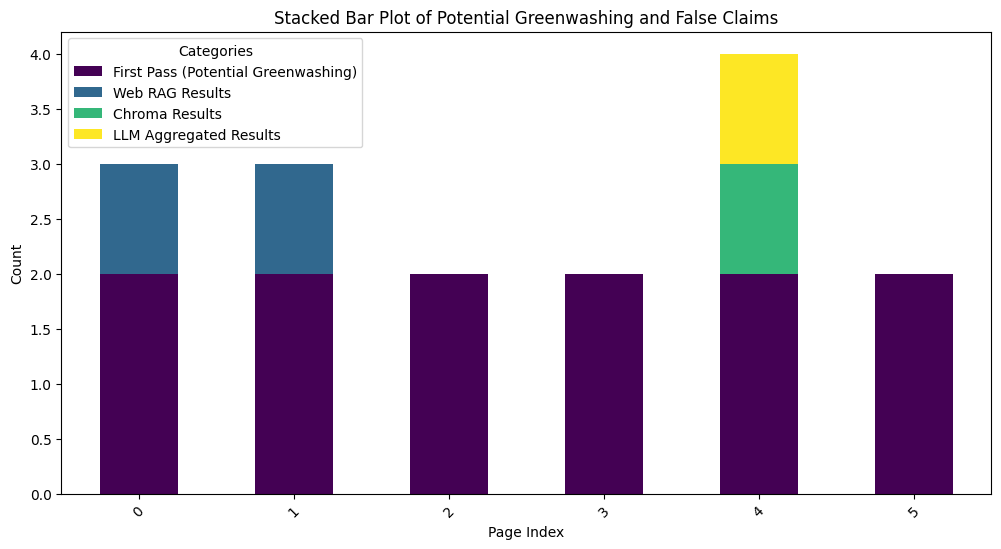

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re

# Load your dataframe (replace this with your actual dataframe loading method)

# Count occurrences of "potential greenwashing" in the "First pass" column
first_pass_count = df["First pass"].str.count("Potential greenwashing", flags=re.IGNORECASE).groupby(df.index).sum()

# Define function to count occurrences of "PARTIALLY FALSE" and "FALSE"
def count_false_statements(columns, df):
    return df[columns].apply(lambda col: col.str.contains("Result of the statement: PARTIALLY FALSE|Result of the statement: FALSE", na=False)).sum(axis=1)

# Aggregate counts for each category
web_rag_count = count_false_statements(["web_rag_result", "web_rag_result_2"], df)
chroma_count = count_false_statements(["chroma_result", "chroma_result_2"], df)
llm_agg_count = count_false_statements(["aggregator_result", "aggregator_result_2"], df)

# Create a new dataframe for plotting
plot_df = pd.DataFrame({
    "First Pass (Potential Greenwashing)": first_pass_count,
    "Web RAG Results": web_rag_count,
    "Chroma Results": chroma_count,
    "LLM Aggregated Results": llm_agg_count
})

# Plot stacked bar chart
ax = plot_df.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='viridis')
plt.xlabel("Page Index")
plt.ylabel("Count")
plt.title("Stacked Bar Plot of Potential Greenwashing and False Claims")
plt.legend(title="Categories")
plt.xticks(np.arange(len(plot_df.index)), plot_df.index, rotation=45)
plt.show()


In [22]:
# fuirst passs last page
print(df.loc[5, "First pass"])

Potential greenwashing claim: "We reduced the volume of water used by 11 million m3, equivalent to a reduction of 45% compared with the base year."
Justification: The claim is based on actual data and targets set in the report. However, it's worth noting that the target was set at 22% reduction, but Hitachi achieved a 27% reduction, which could be seen as an exaggeration or a stretch of the actual achievement.

Potential greenwashing claim: "We are also engaged in verification tests and joint research with national and local governments, companies, and other organizations in various countries to establish new technologies and systems for the water business."
Justification: This claim is vague and lacks specific details about the outcomes of these research activities. It could be seen as a way to create the impression that Hitachi is actively working on innovative solutions without providing concrete evidence.


In [27]:
print(df.loc[4, "chroma_result"])

Statement: The company has achieved a 100% effective utilization rate of waste plastics throughout the entire Hitachi Group by fiscal 2030.
Result of the statement: PARTIALLY FALSE
Justification: 

The statement claims that the company has achieved a 100% effective utilization rate of waste plastics, but according to the provided information, the actual target was set at 77% for fiscal 2022 and achieved 88%. Although the company is making efforts to improve the effective utilization rate, there is no indication that it has reached 100% by fiscal 2030.
